<a href="https://colab.research.google.com/github/DannMacias/corn-leaf-disease-detection/blob/main/05_model_deployment_with_Gradio_app.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b> Model deployment using Gradio app 🌽🚀 </b>

My goals are:
* **Performance**: A model that performs at 90%+ accuracy (I use ResNet50).
* **Speed**: A model that can classify an image at a latency of 0.2 seconds.

In [1]:
# Import basic libraries
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

print(f"torch version: {torch.__version__}")
print(f"torcvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torcvision version: 0.14.1+cu116


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Thu Mar 16 19:49:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    28W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Get helper functions (for training and make predictions) from GitHub repo
# See https://github.com/DannMacias/corn-leaf-disease-detection
# Clone the repo
!git clone https://github.com/DannMacias/corn-leaf-disease-detection

# Move the folder helper_functions
!mv corn-leaf-disease-detection/helper_functions .

# Remove the remaining files from the repo of Google Colab
!rm -rf corn-leaf-disease-detection
from helper_functions import engine, predictions, utils

Cloning into 'corn-leaf-disease-detection'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 65 (delta 23), reused 14 (delta 3), pack-reused 0
Unpacking objects: 100% (65/65), 7.41 MiB | 5.11 MiB/s, done.


# 1. Get the data

In [5]:
# Get the data from Google Drive
!unzip /content/drive/MyDrive/Pytorch_notes/corn-leaf-image-classification/corn-leaf-disease.zip > /dev/null

# Path for the data
data_path = "/content/data"

In [6]:
# Download and import splitfolders
!pip install split-folders
import splitfolders

# Split the data in train set (80%) and test set (20%)
splitfolders.ratio(input = data_path,
                   output = "splitted_data",
                   seed = 42,
                   ratio = (0.8, 0.2),
                   group_prefix = None,
                   move = False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 4188 files [00:00, 5103.03 files/s]


In [7]:
# Setup train and test directories
train_dir = "/content/splitted_data/train"
test_dir = "/content/splitted_data/val"

train_dir, test_dir

('/content/splitted_data/train', '/content/splitted_data/val')

# 2. Create ResNet50 feature extractor model

In [8]:
# Create a ResNet50 feature extractor
def create_resnet50(num_classes: int = 4,
                    seed: int = 42):
  
  # Create ResNet50 pretrained weights, transforms and model
  weights = torchvision.models.ResNet50_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.resnet50(weights = weights)

  # Freeze all the layers in base model
  for param in model.parameters():
    param.requires_grad = False

  # Change the classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.fc = nn.Sequential(
      nn.Linear(in_features = 2048, out_features = num_classes, bias = True)
  )
  
  return model, transforms

In [9]:
# Create ResNet50 model
resnet50, resnet50_transforms = create_resnet50()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# 3. Create Datasets and DataLoaders

In [17]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = resnet50_transforms)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = resnet50_transforms)

# Get the class names
class_names = train_data.classes

# Create DataLoaders
train_dataloader = DataLoader(train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = NUM_WORKERS,
                              pin_memory = True)

test_dataloader = DataLoader(test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False,
                             num_workers = NUM_WORKERS,
                             pin_memory = True)

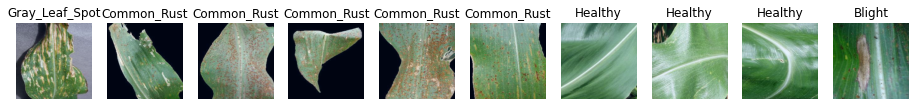

In [18]:
# Visualize the images from the train dataloader
utils.view_dataloader_images(dataloader = train_dataloader,
                             class_names = class_names,
                             num_images = 10)

# 4. Train ResNet50 feature extractor

In [19]:
# Setup learning rate
LEARNING_RATE = 1e-3

# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params = resnet50.parameters(),
                             lr = LEARNING_RATE)

# Train the model
resnet50_results = engine.train(model = resnet50,
                                 train_dataloader = train_dataloader,
                                 test_dataloader = test_dataloader,
                                 optimizer = optimizer,
                                 loss_fn = loss_fn,
                                 epochs = 10,
                                 device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5787 | train_acc: 0.8342 | test_loss: 0.3429 | test_acc: 0.9062
Epoch: 2 | train_loss: 0.2955 | train_acc: 0.9090 | test_loss: 0.2621 | test_acc: 0.9178
Epoch: 3 | train_loss: 0.2406 | train_acc: 0.9229 | test_loss: 0.2371 | test_acc: 0.9213
Epoch: 4 | train_loss: 0.2108 | train_acc: 0.9284 | test_loss: 0.2161 | test_acc: 0.9225
Epoch: 5 | train_loss: 0.1858 | train_acc: 0.9410 | test_loss: 0.2051 | test_acc: 0.9201
Epoch: 6 | train_loss: 0.1731 | train_acc: 0.9424 | test_loss: 0.1921 | test_acc: 0.9248
Epoch: 7 | train_loss: 0.1594 | train_acc: 0.9498 | test_loss: 0.2029 | test_acc: 0.9259
Epoch: 8 | train_loss: 0.1488 | train_acc: 0.9514 | test_loss: 0.1851 | test_acc: 0.9236
Epoch: 9 | train_loss: 0.1397 | train_acc: 0.9540 | test_loss: 0.1787 | test_acc: 0.9294
Epoch: 10 | train_loss: 0.1346 | train_acc: 0.9577 | test_loss: 0.1764 | test_acc: 0.9306


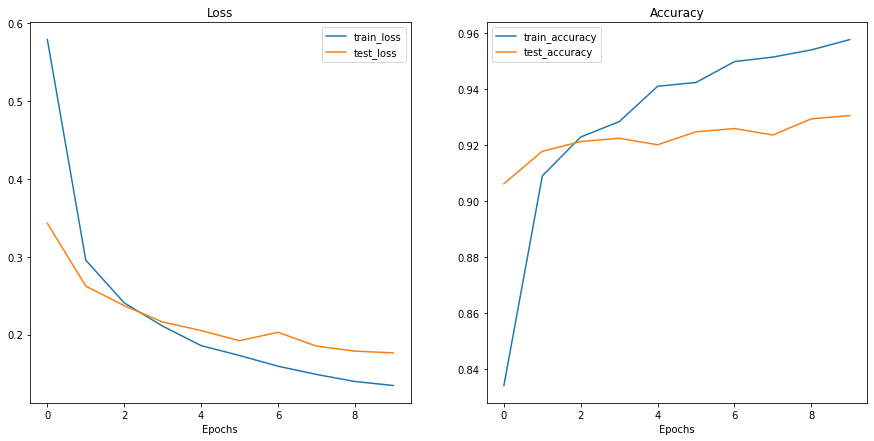

In [20]:
# Inspecting loss curves
utils.plot_loss_curves(resnet50_results)

In [21]:
# Saving the ResNet50 feature extractor model
utils.save_model(model = resnet50,
                 target_dir = "models",
                 model_name = "pretrained_resnet50.pth")

[INFO] Saving model to: models/pretrained_resnet50.pth


# 5. Creating a [Gradio](https://gradio.app/) demo

In [22]:
# Import and install Gradio
try:
  import gradio as gr
except:
  !pip -q install gradio
  import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 KB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 18.8 MB/s eta 0:

## Create a function to map inputs and outputs

Want a function that:

```
input: image -> transform -> predict with GoogleNet -> output: pred, pred_prob, time
```

This will be our `fn` parameter for Gradio Interface.

In [23]:
# Put ResNet50 on CPU
resnet50.to("cpu")

# Check the device
next(iter(resnet50.parameters())).device

device(type='cpu')

Create a function called `predict`.

In [24]:
from typing import Tuple, Dict
from timeit import default_timer as timer

def prediction(img) -> Tuple[Dict, float]:
  """Transforms and performs a prediction in image and returns prediction and time taken.
  """
  # Start the timer
  start_time = timer()

  # Transform the target image and add a batch dimension
  img = resnet50_transforms(img).unsqueeze(dim = 0)

  # Put the model into evaluation and turn on inference mode
  resnet50.eval()
  with torch.inference_mode():
    # Pass the transformed image throught the model and turn the predictions logit into prediction probabilities
    pred_probs = torch.softmax(resnet50(img), dim = 1)

  # Create a prediction label and prediction probability dictionary for each prediction class
  # This is the required format for Gradio's output parameter
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate the prediction time
  pred_time = round(timer() - start_time, 5)

  # Return the prediction dictionary and prediction time
  return pred_labels_and_probs, pred_time

Getting a list of all images paths from the test directory and them randomly selecting one image to pass the `prediction` function.

In [25]:
import random
from pathlib import Path
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_img_path = random.sample(population = test_data_paths, k = 1)[0]

# Open the target image
img = Image.open(random_img_path)

# Predict on the target image and print out the outputs
pred_dict, pred_time = prediction(img = img)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

Prediction label and probability dictionary: 
{'Blight': 5.622870594379492e-05, 'Common_Rust': 0.00026932026958093047, 'Gray_Leaf_Spot': 0.0004008293617516756, 'Healthy': 0.9992735981941223}
Prediction time: 0.27163 seconds


In [26]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k = 3)]
example_list

[['/content/splitted_data/val/Healthy/Corn_Health (825).jpg'],
 ['/content/splitted_data/val/Blight/Corn_Blight (106).jpg'],
 ['/content/splitted_data/val/Healthy/Corn_Health (762).jpg']]

## Building a Gradio Interface

In [27]:
# Create title, description and article string
title = "Corn Leaf Disease Detection 🌽🦠"
description = "An ResNet50 feature extractor computer vision model to classify images of corn leaf as healthy or infected (common rust, bligh and gray leaf spot)"
article = "Created at https://github.com/DannMacias/corn-leaf-disease-detection"

# Create the Gradio demo
demo = gr.Interface(fn = prediction,
                    inputs = gr.Image(type = "pil"),
                    outputs = [gr.Label(num_top_classes = 3, label = "Predictions"),
                               gr.Number(label = "Prediction time (seconds)")],
                    examples = example_list,
                    title = title,
                    description = description,
                    article = article)

# Launch the demo
demo.launch(debug = False, share = True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://8c3b12f84c37b10062.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
